In [1]:
import os
import xml.etree.ElementTree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model
from mrcnn import visualize

import numpy as np
from PIL import Image

import sys

import pandas as pd

ROOT_DIR = os.path.abspath("./")
sys.path.append(ROOT_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, "model")
print(MODEL_DIR)

c:\Users\user\Desktop\Mask-RCNN_forTrain3\model


In [2]:
class NoduleConfig(mrcnn.config.Config):
    NAME = "nod"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    #RPN_ANCHOR_SCALES = (2, 4, 8, 16, 64)
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50




    SAVE_EPOCHES_FREQ_PER_STEP = 5

In [3]:
# Model Configuration
nodule_config = NoduleConfig()

# Build the Mask R-CNN Model Architecture
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir=MODEL_DIR, 
                             config=nodule_config)

# model.load_weights(filepath='mask_rcnn_coco.h5', 
#                    by_name=True, 
#                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
anchors :  Tensor("Squeeze_1:0", shape=(1, None, 4), dtype=float32)


In [59]:
#! 過濾方法(無用)

import tensorflow as tf
import cv2
backbone_shapes = mrcnn.model.compute_backbone_shapes(model.config, model.config.IMAGE_SHAPE)
image = cv2.imread("C:/Users/user/Desktop/hospital/Tumor_original/001/001/0060.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def generate_coord_anchors(x,y,scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)


    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack([box_centers_y, box_centers_x], axis=2).reshape([-1, 2])

    if(feature_stride>=32):
        anchor_coord = []
        for a in range(-1,2):
            for b in range(-1,2):
                #print(a,b)
                anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
                anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
                anchor_coord.append([anchor_y,anchor_x])
        anchor_coord = np.array(anchor_coord)
    else:
        anchor_coord = []
        for a in range(-2,3):
            for b in range(-2,3):
                #print(a,b)
                anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
                anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
                anchor_coord.append([anchor_y,anchor_x])
        anchor_coord = np.array(anchor_coord)
    #print('anchor_coord : ',anchor_coord.shape)


    choose_anchor_tmp = []
    for c in range(anchor_coord.shape[0]):
        choose_anchor_tmp.append(np.all(box_centers == anchor_coord[c], axis=1))

    choose_anchor = choose_anchor_tmp[0]
    for c in range(len(choose_anchor_tmp)-1):
        choose_anchor = choose_anchor | choose_anchor_tmp[c+1]

    choose_anchor = np.array(choose_anchor)

    box_centers = box_centers[choose_anchor] #for anchor


    box_heights = box_heights[:box_centers.shape[0]//3]

    box_widths = box_widths[:box_centers.shape[0]//3]

    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)

    
    return boxes,choose_anchor

def generate_coord_pyramid_anchors(x,y,scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    choose_anchors = []
    #print('scales : ',scales)
    for i in range(len(scales)):
        anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[0])
        choose_anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[1])
    anchors = np.concatenate(anchors, axis=0)
    choose_anchors = np.concatenate(choose_anchors, axis=0).astype(int)
    choose_anchors = np.expand_dims(choose_anchors,axis=1)
    #anchors = np.expand_dims(anchors,axis=0)
    return anchors,choose_anchors

anchor,choose_anchors = generate_coord_pyramid_anchors(110,229,
                model.config.RPN_ANCHOR_SCALES,
                model.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                model.config.BACKBONE_STRIDES,
                model.config.RPN_ANCHOR_STRIDE)
print(anchor.shape)
print(choose_anchors.shape)
choose_anchors = np.expand_dims(choose_anchors,axis=0)

mrcnn.visualize.draw_boxes(image,anchor)

# generate_anchors(220,226,model.config.RPN_ANCHOR_SCALES[0], model.config.RPN_ANCHOR_RATIOS, backbone_shapes[0],
#                                         model.config.BACKBONE_STRIDES[0], model.config.RPN_ANCHOR_STRIDE)

(279, 4)
(65472, 1)
Error in callback <function flush_figures at 0x000002A81433F9D8> (for post_execute):


KeyboardInterrupt: 

(135, 4)
(65472, 1)


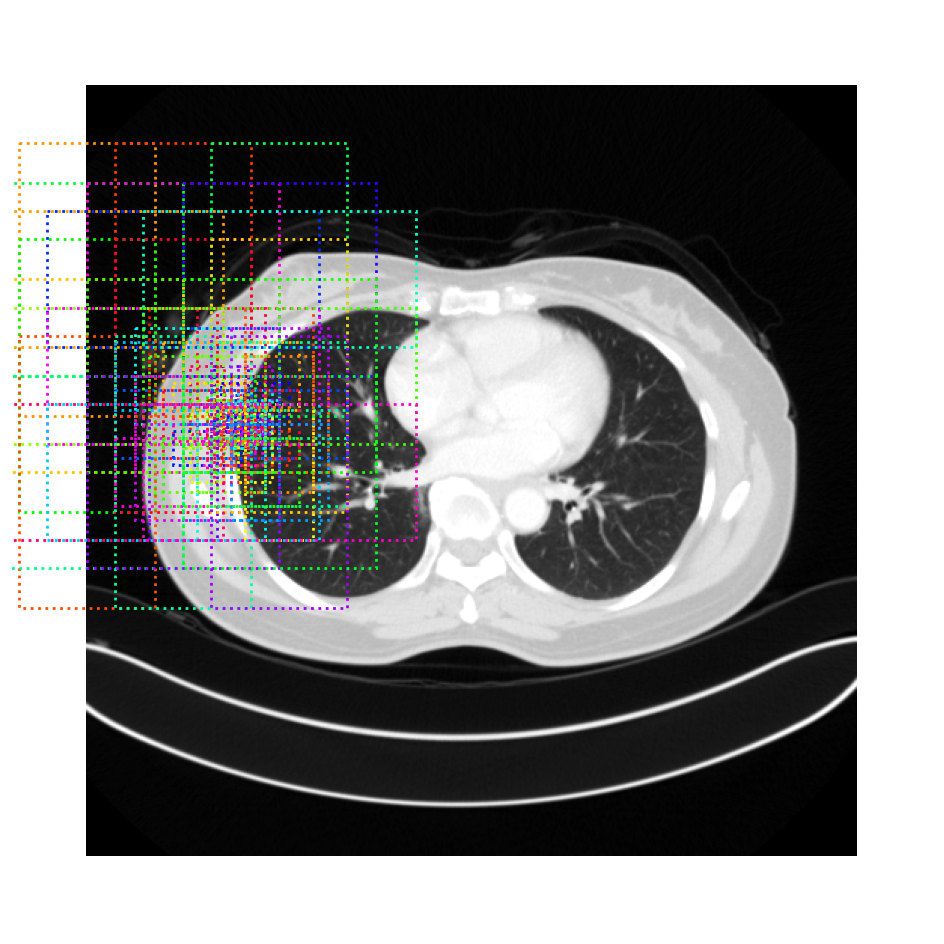

In [4]:
import tensorflow as tf
import cv2
backbone_shapes = mrcnn.model.compute_backbone_shapes(model.config, model.config.IMAGE_SHAPE)
image = cv2.imread("C:/Users/user/Desktop/hospital/Tumor_original/001/001/0060.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def generate_coord_anchors(x,y,scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)
    # print(box_widths.shape)
    # print(box_centers_x.shape)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack([box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    # print('ori_box_centers : ',box_centers.shape)

    #3*3---------------------------------------------------------------------------------------------------    
    anchor_coord = []
    for a in range(-1,2):
        for b in range(-1,2):
            #print(a,b)
            anchor_x = x//feature_stride*(feature_stride)+feature_stride*a
            anchor_y = y//feature_stride*(feature_stride)+feature_stride*b
            anchor_coord.append([anchor_y,anchor_x])
    anchor_coord = np.array(anchor_coord)
    #print('anchor_coord : ',anchor_coord.shape)


    choose_anchor_tmp = []
    for c in range(9):
        choose_anchor_tmp.append(np.all(box_centers == anchor_coord[c], axis=1))

    choose_anchor = choose_anchor_tmp[8]
    for c in range(8):
        choose_anchor = choose_anchor | choose_anchor_tmp[c]

    choose_anchor = np.array(choose_anchor)
    #print('choose_anchor : ',choose_anchor)
    box_centers = box_centers[choose_anchor] #for anchor
    #print('now_box_centers : ',box_centers.shape)


    box_heights = box_heights[:box_centers.shape[0]//3]
    #print('box_heights : ',box_heights.shape)
    box_widths = box_widths[:box_centers.shape[0]//3]
    # print(box_centers.shape)
    # print('box_centers : ')
    # for i in box_heights:
    #     print(i)

    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])
    #print('box_sizes',box_sizes.shape)
    # for i in box_sizes:
    #     print(i)
    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    # print('boxes : ')
    # for i in boxes:
    #     print(i)

    
    return boxes,choose_anchor

def generate_coord_pyramid_anchors(x,y,scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.

    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    choose_anchors = []
    for i in range(len(scales)):
        anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[0])
        choose_anchors.append(generate_coord_anchors(x,y,scales[i], ratios, feature_shapes[i],feature_strides[i], anchor_stride)[1])
    anchors = np.concatenate(anchors, axis=0)
    choose_anchors = np.concatenate(choose_anchors, axis=0).astype(int)
    choose_anchors = np.expand_dims(choose_anchors,axis=1)
    #anchors = np.expand_dims(anchors,axis=0)
    return anchors,choose_anchors

anchor,choose_anchors = generate_coord_pyramid_anchors(110,229,
                model.config.RPN_ANCHOR_SCALES,
                model.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                model.config.BACKBONE_STRIDES,
                model.config.RPN_ANCHOR_STRIDE)
print(anchor.shape)
print(choose_anchors.shape)

mrcnn.visualize.draw_boxes(image,anchor)



In [5]:
maskpath = "C:/Users/user/Desktop/nodule/final/mask/"
original_testing = []
cnt = 35
for fordername in os.listdir(maskpath):
    if(len(os.listdir(maskpath+fordername))!=0):
        cnt-=1
        original_testing.append(int(fordername))
    if(cnt==0):
        break
print(original_testing)
print(len(original_testing))

import random
no_mask = [2,4,5,6,9,17,30,37,67,76,79,81,98,143,152,157,169,177,182,183]
testing_plus15 = random.sample(range(44, 200), 15)
print(testing_plus15)

while(True):
    testing_plus15 = random.sample(range(44, 200), 15)
    for i in testing_plus15:
        if(i in no_mask):
            testing_plus15.remove(i)
            break
    if(len(testing_plus15)==15):
        break
    else:
        continue
testing_plus15.sort()
print(testing_plus15)
print(len(testing_plus15))

testing = original_testing+testing_plus15
print(testing)
print(len(testing))

training = []
for fordername in os.listdir(maskpath):
    if(int(fordername)not in no_mask and (int(fordername) not in testing)):
        training.append(int(fordername))

print(training)
print(len(training))

validation = random.sample(training, 26)
validation.sort()
training  = list(set(training).symmetric_difference(set(validation)))

print(validation)
print(len(validation))
print(training)
print(len(training))

[1, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43]
35


In [1]:
import random
no_mask = [2,4,5,6,9,17,30,37,67,76,79,81,98,143,152,157,169,177,182,183]
original_testing = []
for i in range(1,44):
    if(i not in no_mask):
        original_testing.append(i)
print('original_testing',original_testing)
print('len original_testing',len(original_testing))


testing_minus15 = random.sample(original_testing, 15)
print(testing_minus15)

testing = list(set(original_testing).symmetric_difference(set(testing_minus15)))
print('testing',testing)
print('len testing',len(testing))

training = []
for i in range(44,201):
    if(i not in no_mask):
        training.append(i)

print('training',training)
print('len training',len(training))
training = training+testing_minus15
print('training',training)
print('len training',len(training))

validation = random.sample(training, 26)
validation.sort()
training  = list(set(training).symmetric_difference(set(validation)))

print('-'*30)
print('testing',testing)
print('len testing',len(testing))
print('validation',validation)
print('len validation',len(validation))
print('training',training)
print('len training',len(training))

original_testing [1, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43]
len original_testing 35
[19, 7, 27, 29, 24, 28, 31, 26, 41, 40, 38, 15, 23, 18, 35]
testing [1, 3, 8, 10, 11, 12, 13, 14, 16, 20, 21, 22, 25, 32, 33, 34, 36, 39, 42, 43]
len testing 20
training [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 19

In [6]:
nodulescsv = pd.read_csv("C:/Users/user/Desktop/nodule/nodules.csv")

class NoduleDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        # Adds information (image ID, image path, and annotation file path) about each image in a dictionary.
        self.add_class("dataset", 1, "nodule")

        images_dir = dataset_dir + '/image/'
        annotations_dir = dataset_dir + '/mask/'
        for fordername in os.listdir(images_dir):
            if is_train and  (int(fordername) in testing or  int(fordername) in validation): #>= 150 <=64
                continue
            if not is_train and (int(fordername) in testing or int(fordername) in training):#< 150 >36
                continue
            # if is_train and  (int(fordername)>166 or int(fordername)<=43): #>= 150 <=64
            #     continue
            # if not is_train and int(fordername) <=166:#< 150 >36
            #     continue
            for filename in os.listdir(images_dir+fordername):

                for imagename in os.listdir(images_dir+fordername+'/'+filename):

                    image_id = fordername+'_'+filename +'_'+imagename[:4]
                    img_id = imagename[:4]

                    img_path = images_dir + fordername+'/'+filename+'/'+imagename
                    ann_path = annotations_dir + fordername+'/'+filename+'/'+img_id + '.png'
                    index_loc = nodulescsv.loc[(nodulescsv['patientID'] ==int(fordername)) &(nodulescsv['num'] ==int(filename)) &(nodulescsv['filename'] == int(img_id))]
                    x,y = index_loc.iloc[0]['cordX'],index_loc.iloc[0]['cordY']
                    coord_indice = np.array([[x,y]])
                    anchor,choose_anchors = generate_coord_pyramid_anchors(x,y,
                    model.config.RPN_ANCHOR_SCALES,
                    model.config.RPN_ANCHOR_RATIOS,
                    backbone_shapes,
                    model.config.BACKBONE_STRIDES,
                    model.config.RPN_ANCHOR_STRIDE)

                    self.add_image('dataset', image_id=image_id, path=img_path,index=choose_anchors,annotation=ann_path)

    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = Image.open(info['path'])
        img = np.array(img).astype(np.uint8)
        return img

    # Loads the binary masks for an image.
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        print(path)
        #boxes, w, h = self.extract_boxes(path)
        #masks = zeros([h, w, len(boxes)], dtype='uint8')
        #masks = cv2.imread(path,0)
        masks = Image.open(path)
        masks = np.array(masks).astype(np.uint8)
        masks = np.expand_dims(masks,axis=2)
        class_ids = list()
        # for i in range(len(boxes)):
        #     box = boxes[i]
        #     row_s, row_e = box[1], box[3]
        #     col_s, col_e = box[0], box[2]
        #     masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(self.class_names.index('nodule'))
        return masks, asarray(class_ids, dtype='int32')
    
    def load_index(self, image_id):
        info = self.image_info[image_id]
        index = info['index']
        return index

    # A helper method to extract the bounding boxes from the annotation file
    # def extract_boxes(self, filename):
    #     tree = xml.etree.ElementTree.parse(filename)

    #     root = tree.getroot()

    #     boxes = list()
    #     for box in root.findall('.//bndbox'):
    #         xmin = int(box.find('xmin').text)
    #         ymin = int(box.find('ymin').text)
    #         xmax = int(box.find('xmax').text)
    #         ymax = int(box.find('ymax').text)
    #         coors = [xmin, ymin, xmax, ymax]
    #         boxes.append(coors)

    #     width = int(root.find('.//size/width').text)
    #     height = int(root.find('.//size/height').text)
    #     return boxes, width, height


In [7]:
# Train
train_dataset = NoduleDataset()
train_dataset.load_dataset(dataset_dir='C:/Users/user/Desktop/nodule/final', is_train=True)
train_dataset.prepare()
for i in train_dataset.image_info:
    print(i)

{'id': '001_001_0060', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/001/001/0060.png', 'index': array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'annotation': 'C:/Users/user/Desktop/nodule/final/mask/001/001/0060.png'}
{'id': '001_001_0061', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/001/001/0061.png', 'index': array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'annotation': 'C:/Users/user/Desktop/nodule/final/mask/001/001/0061.png'}
{'id': '001_001_0062', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/001/001/0062.png', 'index': array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'annotation': 'C:/Users/user/Desktop/nodule/final/mask/001/001/0062.png'}
{'id': '001_001_0063', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/001/001/0063.png', 'index': array([[0],
       [0],
       [

In [8]:
# Validation
validation_dataset = NoduleDataset()
validation_dataset.load_dataset(dataset_dir='C:/Users/user/Desktop/nodule/final', is_train=False)
validation_dataset.prepare()
for i in validation_dataset.image_info:
    print(i)

{'id': '049_001_0053', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/049/001/0053.png', 'index': array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'annotation': 'C:/Users/user/Desktop/nodule/final/mask/049/001/0053.png'}
{'id': '049_001_0054', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/049/001/0054.png', 'index': array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'annotation': 'C:/Users/user/Desktop/nodule/final/mask/049/001/0054.png'}
{'id': '049_001_0055', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/049/001/0055.png', 'index': array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), 'annotation': 'C:/Users/user/Desktop/nodule/final/mask/049/001/0055.png'}
{'id': '049_001_0056', 'source': 'dataset', 'path': 'C:/Users/user/Desktop/nodule/final/image/049/001/0056.png', 'index': array([[0],
       [0],
       [

C:/Users/user/Desktop/nodule/final/mask/001/001/0060.png
(512, 512, 3)
(512, 512, 1)
1339
1339
292
this :  [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
(65472, 1)
(65472, 1, 1)


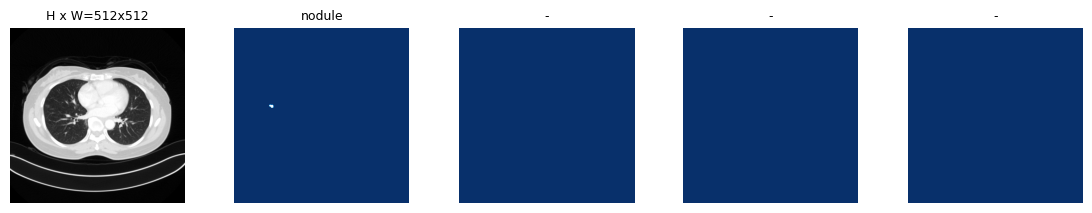

In [9]:
image = train_dataset.load_image(0)
mask,class_id = train_dataset.load_mask(0)
print(image.shape)
print(mask.shape)
print(len(train_dataset.image_ids))
print(train_dataset.num_images)
print(validation_dataset.num_images)
print('this : ' ,train_dataset.image_info[1]['index'])
print(train_dataset.image_info[1]['index'].shape)
temp = np.expand_dims(train_dataset.image_info[1]['index'],axis=1)
print(temp.shape)
visualize.display_top_masks(image,mask,class_id,train_dataset.class_names)

In [10]:
model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=nodule_config.LEARNING_RATE, 
            epochs=30, 
            layers='all')




Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\user\Desktop\Mask-RCNN_forTrain3\model\nod20231009T2003\mask_rcnn_nod_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Con

c:\Users\user\anaconda3\envs\tf2.0test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\user\anaconda3\envs\tf2.0test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\user\anaconda3\envs\tf2.0test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\user\anaconda3\envs\tf2.0test\lib\site-packages\tensorflow\python\framework\

C:/Users/user/Desktop/nodule/final/mask/044/002/0030.png
C:/Users/user/Desktop/nodule/final/mask/146/003/0040.png
C:/Users/user/Desktop/nodule/final/mask/159/001/0050.png
C:/Users/user/Desktop/nodule/final/mask/127/001/0093.png
C:/Users/user/Desktop/nodule/final/mask/173/001/0042.png


c:\Users\user\anaconda3\envs\tf2.0test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


C:/Users/user/Desktop/nodule/final/mask/153/009/0067.png
C:/Users/user/Desktop/nodule/final/mask/195/002/0031.png
C:/Users/user/Desktop/nodule/final/mask/148/001/0036.png
C:/Users/user/Desktop/nodule/final/mask/052/001/0075.png
C:/Users/user/Desktop/nodule/final/mask/192/003/0053.png
C:/Users/user/Desktop/nodule/final/mask/072/001/0064.png
C:/Users/user/Desktop/nodule/final/mask/104/001/0051.png
C:/Users/user/Desktop/nodule/final/mask/149/001/0026.png
C:/Users/user/Desktop/nodule/final/mask/156/001/0043.png
C:/Users/user/Desktop/nodule/final/mask/122/001/0035.png
C:/Users/user/Desktop/nodule/final/mask/179/001/0032.png
C:/Users/user/Desktop/nodule/final/mask/054/004/0050.png
C:/Users/user/Desktop/nodule/final/mask/176/001/0038.png
C:/Users/user/Desktop/nodule/final/mask/064/001/0067.png
C:/Users/user/Desktop/nodule/final/mask/179/001/0027.png
C:/Users/user/Desktop/nodule/final/mask/180/003/0056.png
C:/Users/user/Desktop/nodule/final/mask/166/001/0094.png
C:/Users/user/Desktop/nodule/fi

In [11]:
model_path = MODEL_DIR+'/mask_rcnn_trained_1008_testingminus15.h5'
model.keras_model.save_weights(model_path)